In [1]:
# geopython env + mxnet1.6.0 env
import numpy as np
import pandas as pd
import imageio
import os
from scipy.stats.stats import pearsonr
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix
# import higra as hg

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
%matplotlib inline

In [2]:
# mxnet1.6.0 env
import cv2
import mxnet as mx
from mxnet import gluon
from mxnet import autograd
from mxnet import image

import sys
sys.path.append('../../resuneta/src')
sys.path.append('../../resuneta/nn/loss')
sys.path.append('../../resuneta/models')
sys.path.append('../../')
sys.path.append('../MXNet-ResUNeta/')

from resunet_d6_causal_mtskcolor_ddist import *
from resunet_d7_causal_mtskcolor_ddist import *
from datasets import *

# Instance segmentation post-processing

Instance segmentation function provided by Franz.

In [3]:
def InstSegm(extent, boundary, t_ext=0.4, t_bound=0.2):
    """
    INPUTS:
    extent : extent prediction
    boundary : boundary prediction
    t_ext : threshold for extent
    t_bound : threshold for boundary
    OUTPUT:
    instances
    """

    # Threshold extent mask
    ext_binary = np.uint8(extent >= t_ext)

    # Artificially create strong boundaries for
    # pixels with non-field labels
    input_hws = np.copy(boundary)
    input_hws[ext_binary == 0] = 1

    # Create the directed graph
    size = input_hws.shape[:2]
    graph = hg.get_8_adjacency_graph(size)
    edge_weights = hg.weight_graph(
        graph,
        input_hws,
        hg.WeightFunction.mean
    )

    tree, altitudes = hg.watershed_hierarchy_by_dynamics(
        graph,
        edge_weights
    )
    
    # Get individual fields
    # by cutting the graph using altitude
    instances = hg.labelisation_horizontal_cut_from_threshold(
        tree,
        altitudes,
        threshold=t_bound)
    
    instances[ext_binary == 0] = -1

    return instances

In [4]:
def mcc_from_cm(cm):
    '''
    Computes the Matthews correlation coefficient
    from a 2x2 confusion matrix.
    Each row of the confusion matrix is the actual
    value; each column is the predicted value.
    '''
    tp = cm[0,0]
    tn = cm[1,1]
    fp = cm[1,0]
    fn = cm[0,1]
    
    numerator = float(tp * tn - fp * fn)
    denominator = float((tp+fp) * (tp+fn) * (tn+fp) * (tn+fn))
    denominator = np.sqrt(denominator)
    return numerator / denominator

## Trained on October, no tree or pasture

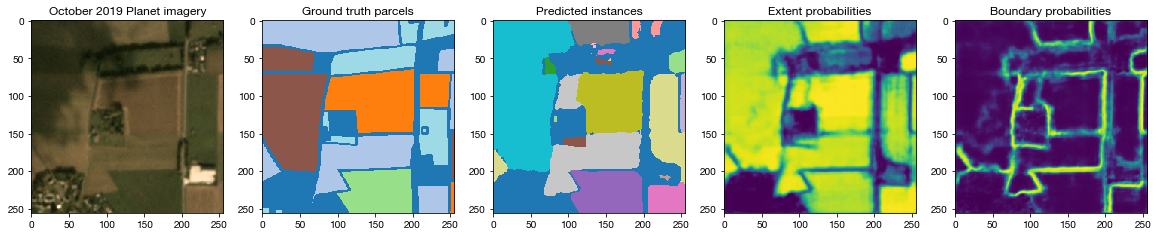

In [78]:
image_id = '00001'

data_dir = '../data/planet/france/sherrie10k/'
example_img = imageio.imread(os.path.join(data_dir, 'monthly_mosaics_renamed_clipped_merged/2019_10/{}_2019_10.tif'.format(image_id)))
example_truth = imageio.imread(os.path.join(data_dir, 'extent_labels/{}.png'.format(image_id)))

results_dir = '../results/france/sherrie10k/resunet-d6_october_class-subset_nfilter-16_bs-8_lr-0.001/'
example_extent = np.load(os.path.join(results_dir, 'extent_predictions/{}.npy'.format(image_id)))
example_boundary = np.load(os.path.join(results_dir, 'boundary_predictions/{}.npy'.format(image_id)))

# instances = InstSegm(example_extent, example_boundary)

# map instances to better range for plotting
unique_instances = sorted(np.unique(instances))
min_instance = unique_instances[1]
max_instance = unique_instances[-1]
n_instances = len(unique_instances)
instance_map = {x: i for i, x in enumerate(unique_instances)}
def map_values(x):
    return instance_map[x]
instances_mapped = np.array(list(map(map_values, instances.flatten()))).reshape( 
    instances.shape[0], instances.shape[1])


fig, ax = plt.subplots(1, 5, figsize=(20,4))
ax[0].imshow(example_img[:256,:256])
ax[0].set_title('October 2019 Planet imagery')
ax[1].imshow(example_truth[:256,:256], vmin=0, vmax=np.max(example_truth), cmap='tab20')
ax[1].set_title('Ground truth parcels')
ax[2].imshow(instances_mapped, vmin=0, vmax=n_instances+1, cmap='tab20')
ax[2].set_title('Predicted instances')
ax[3].imshow(example_extent)
ax[3].set_title('Extent probabilities')
ax[4].imshow(example_boundary)
ax[4].set_title('Boundary probabilities')

plt.show()

# Load and evaluate model

In [5]:
# ==================== USER SETTINGS ==================== #
# models evaluated:
# 'resunet-d6_janAprOct_nfilter-16_bs-8_lr-0.001'

n_filters = 16
n_classes = 1
hsv_channels = 3

# original model
# model_name = 'resunet-d6_aprJulOctSeparate_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001/'

# 4x downsampled
# model_name = 'resunet-d6_aprJulOctSeparate_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_4x-downsampled/'

# 8x downsampled
# model_name = 'resunet-d6_aprJulOctSeparate_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_8x-downsampled/'

# 1x-8x combined
model_name = 'resunet-d6_2019_10_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled/'

file_name = '../experiments/france/sherrie10k/{}/model.params'.format(model_name)
model = ResUNet_d6(_nfilters_init=n_filters, 
                   _NClasses=n_classes,
                   hsv_outchannels=hsv_channels)
gpu = 0
model.load_parameters(file_name, ctx=mx.gpu(gpu))
# ======================================================= #

depth:= 0, nfilters: 16
depth:= 1, nfilters: 32
depth:= 2, nfilters: 64
depth:= 3, nfilters: 128
depth:= 4, nfilters: 256
depth:= 5, nfilters: 512
depth:= 6, nfilters: 256
depth:= 7, nfilters: 128
depth:= 8, nfilters: 64
depth:= 9, nfilters: 32
depth:= 10, nfilters: 16


### Single month

In [6]:
# ==================== USER SETTINGS ==================== #
month = '2019_07'
image_directories = '../data/planet/france/sherrie10k/monthly_mosaics_renamed_clipped_merged/2500px/6x_downsample/{}/'.format(month)
label_directory = '../data/planet/france/sherrie10k/extent_labels/2500px/6x_downsample/'
batch_size = 8

# all classes
# classes = list(np.arange(1,28, dtype=np.uint8))

# no trees except vines are kept as classes to predict
classes = list(range(1,10)) + [11,14,15,16,17,18,19,21,24,25,26,27]
# splits_df = pd.read_csv('../data/splits/sherrie10k_planetImagery_splits_10x10.csv')
splits_df = pd.read_csv('../data/splits/sherrie10k_planetImagery_splits_20x20_2x-downsampled.csv')
splits_df['image_id'] = splits_df['image_id'].astype(str).str.zfill(5)
imgs_in_folder = [x.split('.')[0] for x in os.listdir(label_directory)]
splits_df = splits_df[splits_df['image_id'].isin(imgs_in_folder)].reset_index(drop=True)
save_dir = '../results/france/sherrie10k/{}/{}'.format(model_name, month)
# ======================================================= #

train_names = splits_df[splits_df['fold'] == 'train']['image_id'].values
val_names = splits_df[splits_df['fold'] == 'val']['image_id'].values

# setting fold = 'val' means no data augmentation
train_dataset = PlanetDatasetWithClasses(image_directories, label_directory, classes=classes,
                                         image_names=train_names, fold='val', image_suffix='_{}.tif'.format(month))
val_dataset = PlanetDatasetWithClasses(image_directories, label_directory, classes=classes,
                                       image_names=val_names, fold='val', image_suffix='_{}.tif'.format(month))

train_dataloader = gluon.data.DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = gluon.data.DataLoader(val_dataset, batch_size=batch_size)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    os.makedirs(os.path.join(save_dir, 'boundary_predictions'))
    os.makedirs(os.path.join(save_dir, 'extent_predictions'))

In [7]:
# Save all predictions for training and validation sets
all_dataloaders = {'train': train_dataloader, 'val': val_dataloader}
all_names = {'train': train_names, 'val': val_names}

# initialize metrics
accs = {'train': [], 'val': []}
mccs = {'train': [], 'val': []}
cm = {'train': np.zeros((2,2)), 'val': np.zeros((2,2))}
mxnet_mcc = {'train': mx.metric.MCC(), 'val': mx.metric.MCC()}
sklearn_mcc_batches = {'train': [], 'val': []}
cm_mcc_batches = {'train': [], 'val': []}

# validation set
for fold in all_dataloaders:
    print(fold)
    
    current_dataloader = all_dataloaders[fold]
    for batch_i, (img, extent, boundary, distance, hsv) in enumerate(current_dataloader): # val_dataloader

        if batch_i % 50 == 0:
            print("    batch {}".format(batch_i))
            
        img = img.as_in_context(mx.gpu(gpu))
        extent = extent.as_in_context(mx.gpu(gpu))
        boundary = boundary.as_in_context(mx.gpu(gpu))
        distance = distance.as_in_context(mx.gpu(gpu))
        hsv = hsv.as_in_context(mx.gpu(gpu))

        logits, bound, dist, convc = model(img)

        extent_predicted_classes = mx.nd.ceil(logits[:,[0],:,:] - 0.5)
        boundary_predicted_classes = mx.nd.ceil(bound[:,[0],:,:] - 0.5)

        prediction = logits[:,0,:,:].reshape(-1)
        probabilities = mx.nd.stack(1 - prediction, prediction, axis=1)
        mxnet_mcc[fold].update(extent.reshape(-1), probabilities)
        
        sklearn_mcc_batches[fold].append(matthews_corrcoef(
            extent.asnumpy().astype(np.int8).flatten(),
            extent_predicted_classes.asnumpy().astype(np.int8).flatten()))
        
        batch_cm = confusion_matrix(
            extent.asnumpy().astype(np.int8).flatten(),
            extent_predicted_classes.asnumpy().astype(np.int8).flatten()).astype(np.float64)
        cm_mcc_batches[fold].append(mcc_from_cm(batch_cm))

        for i in range(extent.shape[0]):

            # Update running confusion matrix
            y_true = extent[i].asnumpy().astype(np.int8).flatten()
            y_pred = extent_predicted_classes[i].asnumpy().astype(np.int8).flatten()
            img_cm = confusion_matrix(y_true, y_pred)
            if sum(y_true) == 0: # all zeros
                cm[fold][0,0] = cm[fold][0,0] + img_cm[0,0]
            elif sum(y_true) == len(y_true): # all ones
                cm[fold][1,1] = cm[fold][1,1] + img_cm[0,0]
            else:
                cm[fold] = cm[fold] + img_cm

            # Compute accuracy per image
            acc = accuracy_score(y_true, y_pred)
            accs[fold].append(acc)
            
            # Compute MCC per image
            mcc = matthews_corrcoef(y_true, y_pred)
            mccs[fold].append(mcc)

            # save predictions
#             current_names = all_names[fold]
#             image_id = current_names[batch_i * batch_size + i]
#             np.save(os.path.join(save_dir, 'boundary_predictions/{}.npy'.format(image_id)), bound[i].asnumpy()[0])
#             np.save(os.path.join(save_dir, 'extent_predictions/{}.npy'.format(image_id)), logits[i].asnumpy()[0])

#             if batch_i == 0:
#                 print(current_names[batch_i * batch_size + i], mcc)
#                 print(mcc)
#                 fig, ax = plt.subplots(1,3, figsize=(18,4))
#                 ax[0].imshow(np.moveaxis(img.asnumpy()[i][:3], 0, -1) / 255.)
#     #             ax[1].imshow(np.moveaxis(img.asnumpy()[i][3:6], 0, -1) / 255.)
#     #             ax[2].imshow(np.moveaxis(img.asnumpy()[i][-3:], 0, -1) / 255.)
#                 ax[-2].imshow(np.squeeze(extent[i].asnumpy().astype(np.int8)))
#                 ax[-1].imshow(np.squeeze(extent_predicted_classes[i].asnumpy().astype(np.int8)))
#                 plt.show()




print("Fold-level MCC:")
print("  Train = {}".format(mcc_from_cm(cm['train'])))
print("  Val = {}".format(mcc_from_cm(cm['val'])))

print("Batch-level MCC:")
print("  Train = {}".format(mxnet_mcc['train'].get()[1]))
print("  Val = {}".format(mxnet_mcc['val'].get()[1]))

print("Image-level Metrics:")
results_df = pd.DataFrame({'image_id': list(train_names) + list(val_names),
                           'MCC': mccs['train'] + mccs['val'], 
                           'accuracy': accs['train'] + accs['val']})
results_df = results_df.merge(splits_df, on='image_id', how='inner')

val_df = results_df[results_df['fold'] == 'val']
train_df = results_df[results_df['fold'] == 'train']

print("  Train MCC = {}".format(train_df['MCC'].values.mean()))
print("  Val MCC = {}".format(val_df['MCC'].values.mean()))
print("  Train acc = {}".format(train_df['accuracy'].values.mean()))
print("  Val acc = {}".format(val_df['accuracy'].values.mean()))

train
    batch 0


/home/swang222/anaconda3/envs/mxnet1.6.0/lib/python3.6/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


    batch 50
    batch 100
    batch 150
    batch 200
    batch 250
    batch 300
    batch 350
    batch 400
    batch 450
    batch 500
    batch 550
    batch 600
    batch 650
    batch 700
    batch 750
    batch 800
val
    batch 0
    batch 50
    batch 100
    batch 150
Fold-level MCC:
  Train = 0.6258440054918375
  Val = 0.6592901738492842
Batch-level MCC:
  Train = 0.6181041110371576
  Val = 0.6493053345078276
Image-level Metrics:
  Train MCC = 0.5235206903592868
  Val MCC = 0.5624526526342546
  Train acc = 0.8511436452243363
  Val acc = 0.8591658085160545


In [8]:
results_df.sort_values('image_id').reset_index(drop=True).to_csv(
    '../results/france/sherrie10k/{}/metrics_by_image_6x-downsampled_trainval_{}.csv'.format(model_name, month),
    index=False
)

In [9]:
# 4x downsample
# Apr: 
# Fold-level MCC:
#   Train = 0.6658489567774745
#   Val = 0.701101535165197
# Batch-level MCC:
#   Train = 0.6596910974077311
#   Val = 0.6906858788034026
# Image-level Metrics:
#   Train MCC = 0.5611648203381301
#   Val MCC = 0.6092502807958436
#   Train acc = 0.8498025581776382
#   Val acc = 0.861094337848303

# Jul:
# Fold-level MCC:
#   Train = 0.6704825144337191
#   Val = 0.7019877797861629
# Batch-level MCC:
#   Train = 0.6640512748294674
#   Val = 0.6914902546593369
# Image-level Metrics:
#   Train MCC = 0.5674493716943174
#   Val MCC = 0.6071611012674997
#   Train acc = 0.8529049844709369
#   Val acc = 0.8623374751437682

# Oct:
# Fold-level MCC:
#   Train = 0.6661991375101792
#   Val = 0.7058992186195084
# Batch-level MCC:
#   Train = 0.6601186982317055
#   Val = 0.6957031384062232
# Image-level Metrics:
#   Train MCC = 0.5603891441776719
#   Val MCC = 0.608309682036929
#   Train acc = 0.851013488363172
#   Val acc = 0.863781246762689

(0.6906858788034026 + 0.6914902546593369 + 0.6957031384062232) / 3 # 0.6926264239563209

0.6926264239563209

## Plot results geographically

### MCC

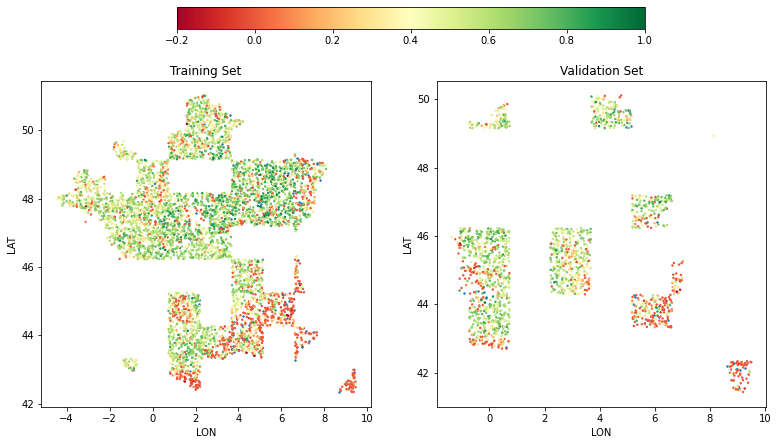

In [13]:
results_df = pd.DataFrame({'image_id': list(train_names) + list(val_names),
                           'MCC': mccs['train'] + mccs['val'], 
                           'accuracy': accs['train'] + accs['val']})
results_df = results_df.merge(splits_df, on='image_id', how='inner')

val_df = results_df[results_df['fold'] == 'val']
train_df = results_df[results_df['fold'] == 'train']

fig, ax = plt.subplots(1,2, figsize=(13,6))
# accuracy is 100%
ax[0].scatter(train_df[train_df['accuracy'] == 1]['lon'], train_df[train_df['accuracy'] == 1]['lat'], 
              color='C0', s=2, cmap='RdYlGn', vmin=-0.2, vmax=1.0)
ax[1].scatter(val_df[val_df['accuracy'] == 1]['lon'], val_df[val_df['accuracy'] == 1]['lat'], 
              color='C0', s=2, cmap='RdYlGn', vmin=-0.2, vmax=1.0)
# accuracy not 100%
im = ax[0].scatter(train_df[train_df['accuracy'] != 1]['lon'], train_df[train_df['accuracy'] != 1]['lat'], 
                   c=train_df[train_df['accuracy'] != 1]['MCC'], s=2, cmap='RdYlGn', vmin=-0.2, vmax=1.0)
ax[1].scatter(val_df[val_df['accuracy'] != 1]['lon'], val_df[val_df['accuracy'] != 1]['lat'], 
              c=val_df[val_df['accuracy'] != 1]['MCC'], s=2, cmap='RdYlGn', vmin=-0.2, vmax=1.0)

for i in range(2):
    ax[i].set_xlabel('LON')
    ax[i].set_ylabel('LAT')
ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')

cax = fig.add_axes([0.27, 1, 0.5, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

plt.show()

### Accuracy

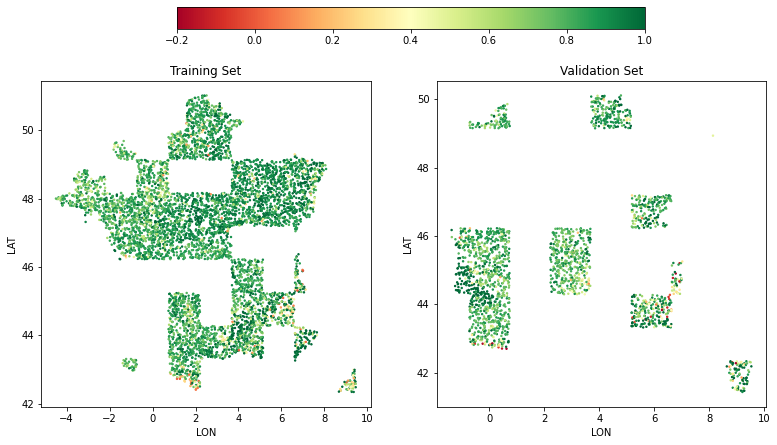

In [15]:
fig, ax = plt.subplots(1,2, figsize=(13,6))
im = ax[0].scatter(train_df['lon'], train_df['lat'], c=train_df['accuracy'], s=2, cmap='RdYlGn', vmin=-0.2, vmax=1.0)
ax[1].scatter(val_df['lon'], val_df['lat'], c=val_df['accuracy'], s=2, cmap='RdYlGn')

for i in range(2):
    ax[i].set_xlabel('LON')
    ax[i].set_ylabel('LAT')
ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')

cax = fig.add_axes([0.27, 1, 0.5, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

plt.show()

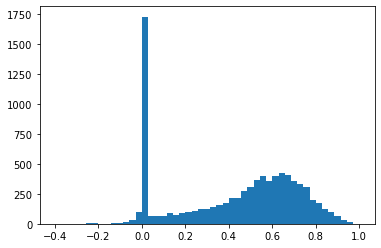

In [15]:
plt.hist(mccs, bins=np.linspace(-0.4,1))
plt.show()

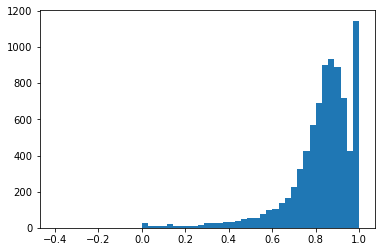

In [15]:
plt.hist(accs, bins=np.linspace(-0.4,1))
plt.show()

### Three-month consensus

In [138]:
# ==================== USER SETTINGS ==================== #
month = '3month_consensus'
months = ['2019_10', '2019_07', '2019_04']
image_directories = ['../data/planet/france/sherrie10k/monthly_mosaics_renamed_clipped_merged/{}/'.format(x) 
                     for x in months]
label_directory = '../data/planet/france/sherrie10k/extent_labels/'
batch_size = 8

# all classes
all_classes = list(np.arange(1,28, dtype=np.uint8))

# no trees except vines are kept as classes to predict
classes = list(range(1,10)) + [11,14,15,16,17,18,19,21,24,25,26] # no misc (28) for now

splits_df = pd.read_csv('../data/splits/sherrie10k_planetImagery_splits_10x10.csv')
splits_df['image_id'] = splits_df['image_id'].astype(str).str.zfill(5)
save_dir = '../results/france/sherrie10k/{}/{}'.format(model_name, month)
# ======================================================= #

train_names = splits_df[splits_df['fold'] == 'train']['image_id'].values
val_names = splits_df[splits_df['fold'] == 'val']['image_id'].values

# setting fold = 'val' means no data augmentation
train_dataset = PlanetMultitempWithClasses(image_directories, label_directory, classes=classes,
                                           image_names=train_names, fold='val', 
                                           image_suffixes=['_{}.tif'.format(x) for x in months])
val_dataset = PlanetMultitempWithClasses(image_directories, label_directory, classes=classes,
                                         image_names=val_names, fold='val', 
                                         image_suffixes=['_{}.tif'.format(x) for x in months])

train_dataloader = gluon.data.DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = gluon.data.DataLoader(val_dataset, batch_size=batch_size)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    os.makedirs(os.path.join(save_dir, 'boundary_predictions'))
    os.makedirs(os.path.join(save_dir, 'extent_predictions'))

In [139]:
# Save all predictions for training and validation sets
all_dataloaders = {'train': train_dataloader, 'val': val_dataloader}
all_names = {'train': train_names, 'val': val_names}

# initialize metrics
accs = {'train': [], 'val': []}
mccs = {'train': [], 'val': []}
cm = {'train': np.zeros((2,2)), 'val': np.zeros((2,2))}
mxnet_mcc = {'train': mx.metric.MCC(), 'val': mx.metric.MCC()}
sklearn_mcc_batches = {'train': [], 'val': []}
cm_mcc_batches = {'train': [], 'val': []}
recalls = {'train': [], 'val': []}
by_crop_type = {'train': {x: 0 for x in all_classes}, 
                'val': {x: 0 for x in all_classes},
                'train_total': {x: 0 for x in all_classes}, 
                'val_total': {x: 0 for x in all_classes}}
precisions = {'train': [], 'val': []}
true_pos = {'train': 0, 'val': 0}
false_pos = {'train': 0, 'val': 0}
false_neg = {'train': 0, 'val': 0}
class_compositions = {'train': np.zeros((len(train_names), 29)),
                      'val': np.zeros((len(val_names), 29))}

# validation set
for fold in all_dataloaders:
    print(fold)
    
    current_dataloader = all_dataloaders[fold]
    for batch_i, (img, extent, boundary, distance, hsv) in enumerate(current_dataloader): # val_dataloader

        if batch_i % 50 == 0:
            print("    batch {}".format(batch_i))
            
        img = img.as_in_context(mx.gpu(gpu))
        extent = extent.as_in_context(mx.gpu(gpu))
        boundary = boundary.as_in_context(mx.gpu(gpu))
        distance = distance.as_in_context(mx.gpu(gpu))
        hsv = hsv.as_in_context(mx.gpu(gpu))

        logits1, bound1, dist1, convc1 = model(img[:,:3]) # october
        logits2, bound2, dist2, convc2 = model(img[:,3:6]) # july
        logits3, bound3, dist3, convc3 = model(img[:,6:9]) # april 
        logits = (logits1 + logits2 + logits3) / 3.
        bound = (bound1 + bound2 + bound3) / 3.

        extent_predicted_classes = mx.nd.ceil(logits[:,[0],:,:] - 0.5)
        boundary_predicted_classes = mx.nd.ceil(bound[:,[0],:,:] - 0.5)

        prediction = logits[:,0,:,:].reshape(-1)
        probabilities = mx.nd.stack(1 - prediction, prediction, axis=1)
        mxnet_mcc[fold].update(extent.reshape(-1), probabilities)
        
        extent_numpy_flat = extent.asnumpy().astype(np.int8).flatten()
        predicted_numpy_flat = extent_predicted_classes.asnumpy().astype(np.int8).flatten()
        sklearn_mcc_batches[fold].append(matthews_corrcoef(
            extent_numpy_flat, predicted_numpy_flat))
        
        batch_cm = confusion_matrix(
            extent_numpy_flat, predicted_numpy_flat).astype(np.float64)
        cm_mcc_batches[fold].append(mcc_from_cm(batch_cm))
        
        true_pos[fold] += np.sum(np.logical_and(extent_numpy_flat == 1, predicted_numpy_flat == 1))
        false_pos[fold] += np.sum(np.logical_and(extent_numpy_flat == 0, predicted_numpy_flat == 1))
        false_neg[fold] += np.sum(np.logical_and(extent_numpy_flat == 1, predicted_numpy_flat == 0))

        for i in range(extent.shape[0]):

            # Update running confusion matrix
            y_true = extent[i].asnumpy().astype(np.int8).flatten()
            y_pred = extent_predicted_classes[i].asnumpy().astype(np.int8).flatten()
            img_cm = confusion_matrix(y_true, y_pred)
            if sum(y_true) == 0: # all zeros
                cm[fold][0,0] = cm[fold][0,0] + img_cm[0,0]
            elif sum(y_true) == len(y_true): # all ones
                cm[fold][1,1] = cm[fold][1,1] + img_cm[0,0]
            else:
                cm[fold] = cm[fold] + img_cm

            # Compute accuracy per image
            acc = accuracy_score(y_true, y_pred)
            accs[fold].append(acc)
            
            # Compute MCC per image
            mcc = matthews_corrcoef(y_true, y_pred)
            mccs[fold].append(mcc)
            
            # Compute recall and precision per image
            recalls[fold].append(np.sum(np.logical_and(y_true == 1, y_pred == 1)) / np.sum(y_true))
            precisions[fold].append(np.sum(np.logical_and(y_true == 1, y_pred == 1)) / np.sum(y_pred))
            
            # Metrics by crop type
            current_names = all_names[fold]
            image_id = current_names[batch_i * batch_size + i]
            original_extent = np.zeros((256, 256))
            original_extent_raw = imageio.imread(os.path.join(label_directory, image_id+'.png'))
            nrow, ncol = original_extent_raw.shape
            original_extent[:nrow, :ncol] = original_extent_raw[:256, :256]
            for parcel_id in all_classes:
                original_extent_class = np.array(original_extent == parcel_id).flatten()
                by_crop_type[fold][parcel_id] += np.sum(np.logical_and(original_extent_class, y_pred))
                by_crop_type[fold+'_total'][parcel_id] += np.sum(original_extent_class)
                class_compositions[fold][batch_i * batch_size + i, parcel_id] += np.sum(original_extent_class)

#            # save predictions
#             np.save(os.path.join(save_dir, 'boundary_predictions/{}.npy'.format(image_id)), bound[i].asnumpy()[0])
#             np.save(os.path.join(save_dir, 'extent_predictions/{}.npy'.format(image_id)), logits[i].asnumpy()[0])

#             if batch_i == 0:
#                 print(val_names[batch_i * batch_size + i], mcc)
#                 print(mxnet_mcc.get()[1])
#                 fig, ax = plt.subplots(1,3, figsize=(18,4))
#                 ax[0].imshow(np.moveaxis(img.asnumpy()[i][:3], 0, -1) / 255.)
#     #             ax[1].imshow(np.moveaxis(img.asnumpy()[i][3:6], 0, -1) / 255.)
#     #             ax[2].imshow(np.moveaxis(img.asnumpy()[i][-3:], 0, -1) / 255.)
#                 ax[-2].imshow(np.squeeze(extent[i].asnumpy().astype(np.int8)))
#                 ax[-1].imshow(np.squeeze(extent_predicted_classes[i].asnumpy().astype(np.int8)))
#                 plt.show()

train
    batch 0


/home/swang222/anaconda3/envs/mxnet1.6.0/lib/python3.6/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in long_scalars
/home/swang222/anaconda3/envs/mxnet1.6.0/lib/python3.6/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in long_scalars


    batch 50
    batch 100
    batch 150
    batch 200
    batch 250
    batch 300
    batch 350
    batch 400
    batch 450
    batch 500
    batch 550
    batch 600
    batch 650
    batch 700
    batch 750
val
    batch 0
    batch 50
    batch 100
    batch 150
    batch 200
    batch 250


In [219]:
print("Fold-level MCC:")
print("  Train = {}".format(mcc_from_cm(cm['train'])))
print("  Val = {}".format(mcc_from_cm(cm['val'])))

print("Batch-level MCC:")
print("  Train = {}".format(mxnet_mcc['train'].get()[1]))
print("  Val = {}".format(mxnet_mcc['val'].get()[1]))

print("Image-level Metrics:")
field_crops = np.array(list(np.arange(1,10)) + [14,15,16])
pasture_crops = np.arange(17, 20)
results_df = pd.DataFrame({'image_id': list(train_names) + list(val_names),
                           'MCC': mccs['train'] + mccs['val'], 
                           'accuracy': accs['train'] + accs['val'],
                           'precision': precisions['train'] + precisions['val'],
                           'recall': recalls['train'] + recalls['val']})
for i in list(range(1,10)) + [11,14,15,16,17,18,19,21,24,25,26,28]:
    results_df['class {}'.format(i)] = list(class_compositions['train'][:,i]) + list(class_compositions['val'][:,i])
results_df = results_df.merge(splits_df, on='image_id', how='inner')

val_df = results_df[results_df['fold'] == 'val']
train_df = results_df[results_df['fold'] == 'train']

print("  Train MCC = {}".format(train_df['MCC'].values.mean()))
print("  Val MCC = {}".format(val_df['MCC'].values.mean()))
print("  Train acc = {}".format(train_df['accuracy'].values.mean()))
print("  Val acc = {}".format(val_df['accuracy'].values.mean()))

Fold-level MCC:
  Train = 0.7421359251133414
  Val = 0.6888592151441992
Batch-level MCC:
  Train = 0.7280267281922963
  Val = 0.6750088969809183
Image-level Metrics:
  Train MCC = 0.5263868131624079
  Val MCC = 0.4496118741241361
  Train acc = 0.8684099278387646
  Val acc = 0.8470455961407356


In [221]:
# results_df.to_csv(
#     '../results/france/sherrie10k/resunet-d6_aprJulOctSeparate_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001/' +
#     '3month_consensus/results.csv', index=False)

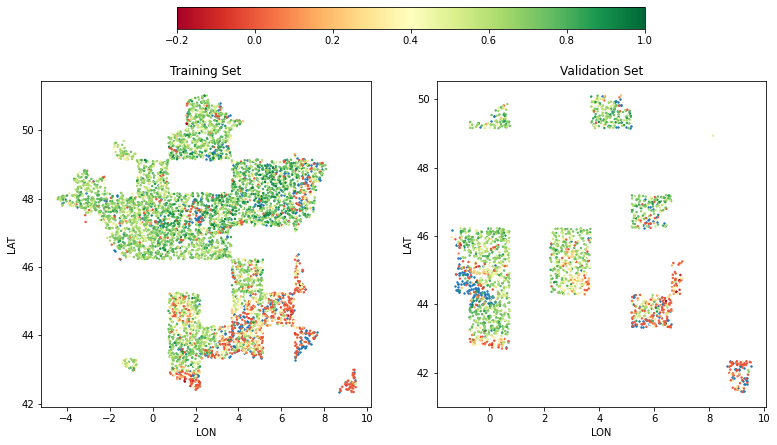

In [190]:
fig, ax = plt.subplots(1,2, figsize=(13,6))
# accuracy is 100%
ax[0].scatter(train_df[train_df['accuracy'] == 1]['lon'], train_df[train_df['accuracy'] == 1]['lat'], 
              color='C0', s=2, cmap='RdYlGn', vmin=-0.2, vmax=1.0)
ax[1].scatter(val_df[val_df['accuracy'] == 1]['lon'], val_df[val_df['accuracy'] == 1]['lat'], 
              color='C0', s=2, cmap='RdYlGn', vmin=-0.2, vmax=1.0)
# accuracy not 100%
im = ax[0].scatter(train_df[train_df['accuracy'] != 1]['lon'], train_df[train_df['accuracy'] != 1]['lat'], 
                   c=train_df[train_df['accuracy'] != 1]['MCC'], s=2, cmap='RdYlGn', vmin=-0.2, vmax=1.0)
ax[1].scatter(val_df[val_df['accuracy'] != 1]['lon'], val_df[val_df['accuracy'] != 1]['lat'], 
              c=val_df[val_df['accuracy'] != 1]['MCC'], s=2, cmap='RdYlGn', vmin=-0.2, vmax=1.0)

for i in range(2):
    ax[i].set_xlabel('LON')
    ax[i].set_ylabel('LAT')
ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')

cax = fig.add_axes([0.27, 1, 0.5, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

plt.show()

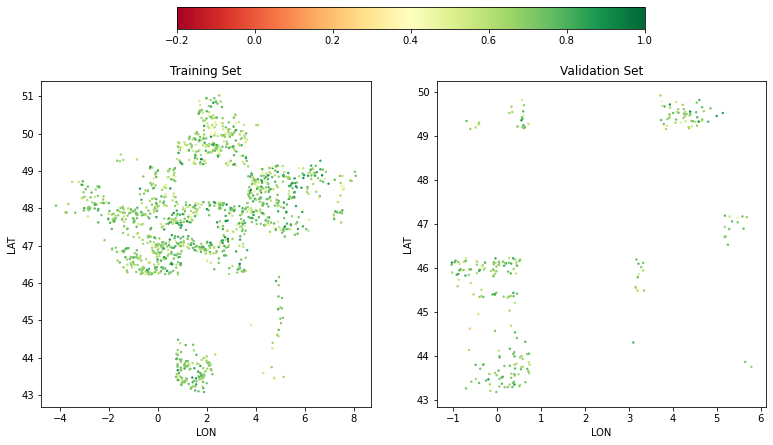

In [191]:
fig, ax = plt.subplots(1,2, figsize=(13,6))
# accuracy is 100%
ax[0].scatter(train_df[(train_df['n_fieldcrop'] > 32768) & (train_df['accuracy'] == 1)]['lon'], 
              train_df[(train_df['n_fieldcrop'] > 32768) & (train_df['accuracy'] == 1)]['lat'], 
              color='C0', s=2, cmap='RdYlGn', vmin=-0.2, vmax=1.0)
ax[1].scatter(val_df[(val_df['n_fieldcrop'] > 32768) & (val_df['accuracy'] == 1)]['lon'], 
              val_df[(val_df['n_fieldcrop'] > 32768) & (val_df['accuracy'] == 1)]['lat'], 
              color='C0', s=2, cmap='RdYlGn', vmin=-0.2, vmax=1.0)
# accuracy not 100%
im = ax[0].scatter(train_df[(train_df['n_fieldcrop'] > 32768) & (train_df['accuracy'] != 1)]['lon'], 
                   train_df[(train_df['n_fieldcrop'] > 32768) & (train_df['accuracy'] != 1)]['lat'], 
                   c=train_df[(train_df['n_fieldcrop'] > 32768) & (train_df['accuracy'] != 1)]['MCC'],
                   s=2, cmap='RdYlGn', vmin=-0.2, vmax=1.0)
ax[1].scatter(val_df[(val_df['n_fieldcrop'] > 32768) & (val_df['accuracy'] != 1)]['lon'], 
              val_df[(val_df['n_fieldcrop'] > 32768) & (val_df['accuracy'] != 1)]['lat'], 
              c=val_df[(val_df['n_fieldcrop'] > 32768) & (val_df['accuracy'] != 1)]['MCC'], 
              s=2, cmap='RdYlGn', vmin=-0.2, vmax=1.0)

for i in range(2):
    ax[i].set_xlabel('LON')
    ax[i].set_ylabel('LAT')
ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')

cax = fig.add_axes([0.27, 1, 0.5, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

plt.show()

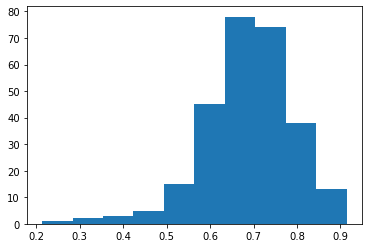

In [192]:
plt.hist(val_df[(val_df['n_fieldcrop'] > 32768) & (val_df['accuracy'] != 1)]['MCC'])
plt.show()

In [113]:
N = 29
test_cmap = 'nipy_spectral'
segmented_cmap = colors.ListedColormap(plt.get_cmap(test_cmap)(np.linspace(0,1,N)))

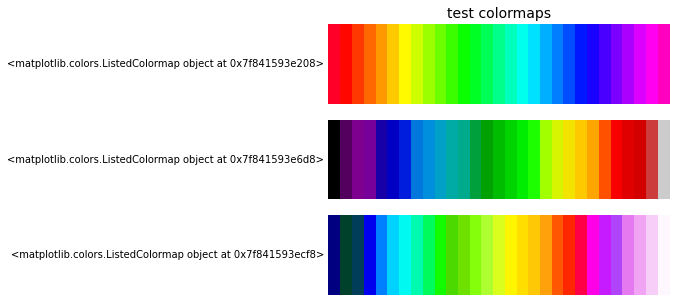

In [116]:
N = 29
test_cmaps = ['gist_rainbow','nipy_spectral','gist_ncar']
segmented_cmaps = [colors.ListedColormap(plt.get_cmap(t)(np.linspace(0,1,N))) for t in test_cmaps]


nrows = len(test_cmaps)
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(cmap_category, cmap_list, nrows):
    fig, axes = plt.subplots(nrows=nrows)
    fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
    axes[0].set_title(cmap_category + ' colormaps', fontsize=14)

    for ax, name in zip(axes, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        pos = list(ax.get_position().bounds)
        x_text = pos[0] - 0.01
        y_text = pos[1] + pos[3]/2.
        fig.text(x_text, y_text, name, va='center', ha='right', fontsize=10)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axes:
        ax.set_axis_off()

plot_color_gradients('test', segmented_cmaps, nrows)
plt.show()


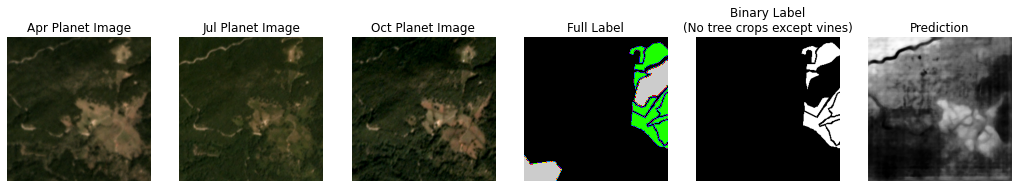

In [133]:
# precision
random_image_id = val_df[val_df['precision'] < 0.1].sample(n=1)['image_id'].values[0]
img_apr = imageio.imread(os.path.join(image_directories[2], '{}_2019_04.tif'.format(random_image_id)))[:256,:256]
img_jul = imageio.imread(os.path.join(image_directories[1], '{}_2019_07.tif'.format(random_image_id)))[:256,:256]
img_oct = imageio.imread(os.path.join(image_directories[0], '{}_2019_10.tif'.format(random_image_id)))[:256,:256]
label = imageio.imread(os.path.join(label_directory, '{}.png'.format(random_image_id)))
label_processed = np.array(np.isin(label, classes), dtype=np.uint8)
pred = np.load(os.path.join(save_dir, 'extent_predictions', '{}.npy'.format(random_image_id)))

ncols = 6
fig, ax = plt.subplots(1, ncols, figsize=(18,3))
ax[0].imshow(img_apr)
ax[1].imshow(img_jul)
ax[2].imshow(img_oct)
ax[3].imshow(label, cmap=segmented_cmap, vmin=0, vmax=28)
ax[4].imshow(label_processed, cmap='Greys_r')
ax[5].imshow(pred, cmap='Greys_r')

ax[0].set_title('Apr Planet Image')
ax[1].set_title('Jul Planet Image')
ax[2].set_title('Oct Planet Image')
ax[3].set_title('Full Label')
ax[4].set_title('Binary Label\n(No tree crops except vines)')
ax[5].set_title('Prediction')

for i in range(ncols):
    ax[i].axis('off')
plt.show()

In [141]:
# recall
print("Overall train recall: {}".format(cm['train'][1,1] / (cm['train'][1,1] + cm['train'][1,0])))
print("Overall train precision: {}".format(cm['train'][1,1] / (cm['train'][1,1] + cm['train'][0,1])))
print("Overall val recall: {}".format(cm['val'][1,1] / (cm['val'][1,1] + cm['val'][1,0])))
print("Overall val precision: {}".format(cm['val'][1,1] / (cm['val'][1,1] + cm['val'][0,1])))

Overall train recall: 0.8385309219954223
Overall train precision: 0.8793528215959333
Overall val recall: 0.7750112480003721
Overall val precision: 0.8531990314185153


In [59]:
crop_coding = pd.read_csv('../mount/data/france_parcels/Codification_cultures_principales_2019.csv')
crop_coding = crop_coding.groupby(['Code Groupe Culture', 'Culture group']).size().reset_index()[['Code Groupe Culture', 'Culture group']]
crop_dict = {}
for parcel_id in crop_coding['Code Groupe Culture'].values:
    crop_dict[parcel_id] = crop_coding[crop_coding['Code Groupe Culture'] == parcel_id]['Culture group'].values[0]

In [64]:
for fold in ['train', 'val']:
    print(fold)
    for parcel_id in crop_dict:
        if parcel_id in by_crop_type[fold]:
            class_recall = by_crop_type[fold][parcel_id] / by_crop_type[fold+'_total'][parcel_id]
            print('  {}, {}: {}'.format(parcel_id, crop_dict[parcel_id], class_recall))

train
  1, soft wheat: 0.9411035108810814
  2, grain corn and silage: 0.9100154849567007
  3, barley: 0.9383083001626938
  4, other grains: 0.9018337377002654
  5, rapeseed: 0.9492131989321075
  6, sunflower: 0.9256507043914707
  7, other oilseeds: 0.9208587078928091
  8, high-protein legumes: 0.940201314004063
  9, fiber plants: 0.9611076132348217
  11, frost (frozen surfaces without production): 0.6205221225003936
  14, rice: 0.8765214643971407
  15, grain pulses: 0.9257508531649815
  16, feed: 0.8905142688630926
  17, summer pastures and moors: 0.2911432774333968
  18, permanent meadows: 0.7719911126327177
  19, temporary meadows: 0.8715026403225073
  20, orchards: 0.512442426491454
  21, vines: 0.6120064377638939
  22, nuts: 0.33937509660083937
  23, olive trees: 0.17677581168457626
  24, other industrial crops: 0.9553622241896292
  25, vegetables or flowers: 0.9119202766824211
  26, sugarcane: nan
val
  1, soft wheat: 0.9351024395979989
  2, grain corn and silage: 0.90250596487537

/home/swang222/anaconda3/envs/mxnet1.6.0/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in long_scalars


In [206]:
val_df[val_df['recall'] < 0.1].shape

(261, 9)

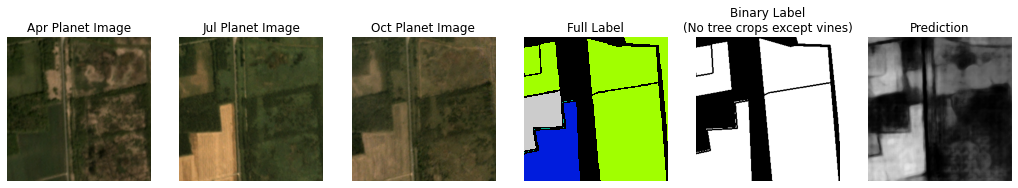

In [218]:
# recall examples
random_image_id = val_df[(val_df['recall'] < 0.4) & (val_df['recall'] > 0.2)].sample(n=1)['image_id'].values[0]
img_apr = imageio.imread(os.path.join(image_directories[2], '{}_2019_04.tif'.format(random_image_id)))[:256,:256]
img_jul = imageio.imread(os.path.join(image_directories[1], '{}_2019_07.tif'.format(random_image_id)))[:256,:256]
img_oct = imageio.imread(os.path.join(image_directories[0], '{}_2019_10.tif'.format(random_image_id)))[:256,:256]
label = imageio.imread(os.path.join(label_directory, '{}.png'.format(random_image_id)))
label_processed = np.array(np.isin(label, classes), dtype=np.uint8)
pred = np.load(os.path.join(save_dir, 'extent_predictions', '{}.npy'.format(random_image_id)))

ncols = 6
fig, ax = plt.subplots(1, ncols, figsize=(18,3))
ax[0].imshow(img_apr)
ax[1].imshow(img_jul)
ax[2].imshow(img_oct)
ax[3].imshow(label, cmap=segmented_cmap, vmin=0, vmax=28, interpolation='nearest')
ax[4].imshow(label_processed, cmap='Greys_r')
ax[5].imshow(pred, cmap='Greys_r', vmin=0, vmax=1)

ax[0].set_title('Apr Planet Image')
ax[1].set_title('Jul Planet Image')
ax[2].set_title('Oct Planet Image')
ax[3].set_title('Full Label')
ax[4].set_title('Binary Label\n(No tree crops except vines)')
ax[5].set_title('Prediction')

for i in range(ncols):
    ax[i].axis('off')
plt.show()

In [172]:
# class_compositions['train'][:,np.where(class_compositions['train'].sum(axis=0) != 0)[0]] / 1000

In [189]:
# field crop
results_df[results_df['n_fieldcrop'] > 30000].mean()

image_id                inf
MCC            6.908555e-01
accuracy       8.976474e-01
precision      9.262829e-01
recall         9.343299e-01
n_fieldcrop    4.232255e+04
lat            4.750772e+01
lon            1.847989e+00
dtype: float64

## Debug MCC

In [73]:
test_mcc = mx.metric.MCC()
example_true = mx.nd.array([0,0,0,0,0,1,1,1,1,1])
example_pred = mx.nd.array([[0.9,0.1],
                            [0.9,0.1],
                            [0.9,0.1],
                            [0.9,0.1],
                            [0.9,0.1],
                            [0.1,0.9],
                            [0.1,0.9],
                            [0.8,0.2],
                            [0.1,0.9],
                            [0.1,0.9]])

example_true2 = mx.nd.array([0,0,0,0,0,1,1,1,1,1])
example_pred2 = mx.nd.array([[0.1,0.9],
                             [0.3,0.7],
                             [0.9,0.1],
                             [0.9,0.1],
                             [0.9,0.1],
                             [0.1,0.9],
                             [0.1,0.9],
                             [0.8,0.2],
                             [0.1,0.9],
                             [0.1,0.9]])

test_mcc.update(example_true, example_pred)
test_mcc.update(example_true2, example_pred2)
print(test_mcc.get()[1])

0.6123724356957945


In [84]:
test_mcc = mx.metric.MCC()
example_true = mx.nd.array([0,0,0,0,0,1,1,1,1,1])
example_pred = mx.nd.array([[0.9,0.1],
                            [0.9,0.1],
                            [0.9,0.1],
                            [0.9,0.1],
                            [0.9,0.1],
                            [0.1,0.9],
                            [0.1,0.9],
                            [0.8,0.2],
                            [0.1,0.9],
                            [0.1,0.9]])

example_true2 = mx.nd.array([0,0,0,0,0,0,0,0,0,0])
example_pred2 = mx.nd.array([[0.9,0.1],
                             [0.9,0.1],
                             [0.9,0.1],
                             [0.9,0.1],
                             [0.9,0.1],
                             [0.9,0.1],
                             [0.9,0.1],
                             [0.9,0.1],
                             [0.9,0.1],
                             [0.9,0.1]])

test_mcc.update(example_true, example_pred)
test_mcc.update(example_true2, example_pred2)
print(test_mcc.get()[1])

0.408248290463863


In [85]:
example_pred_argmax = example_pred.asnumpy().argmax(axis=1)
example_pred_argmax2 = example_pred2.asnumpy().argmax(axis=1)
sklearn_mcc = matthews_corrcoef(example_true.asnumpy(), example_pred_argmax)
sklearn_mcc2 = matthews_corrcoef(example_true2.asnumpy(), example_pred_argmax2)
print(sklearn_mcc)
print(sklearn_mcc2)
print(np.mean([sklearn_mcc, sklearn_mcc2]))

0.816496580927726
0.0
0.408248290463863


/home/swang222/anaconda3/envs/mxnet1.6.0/lib/python3.6/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [83]:
example_cm = confusion_matrix(example_true.asnumpy(), example_pred_argmax)
example_cm2 = confusion_matrix(example_true2.asnumpy(), example_pred_argmax2)
mcc_from_cm(example_cm+example_cm2)

60
100.0


0.6

In [79]:
example_cm+example_cm2

array([[8, 2],
       [2, 8]])

In [80]:
example_cm

array([[5, 0],
       [1, 4]])

In [78]:
example_cm2

array([[3, 2],
       [1, 4]])